## Pre-requisites

### Install the required packages

1. `pip install metatensor`
1. `pip install chemiscope`
1. `pip install
   git+https://github.com/luthaf/rascaline.git@b2cedfe870541e6d037357db58de1901eb116c41`




**NOTE**: this notebook has only been tested on the HPC system "jed". Due to
specific compilation of the quantum chemistry package `FHI-aims`, the Python
interface to running QC calculations may not be generalized to other operating
systems or hardware.

In [9]:
%load_ext autoreload
%autoreload 2

# Useful standard and scientific ML libraries
import os
import time
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol
import torch

# M-Stack packages
import metatensor   # storage format for atomistic ML
import chemiscope  # interactive molecular visualization
import rascaline   # generating structural representations
from metatensor import Labels, TensorBlock, TensorMap
from rascaline.utils import clebsch_gordan

# Interfacing with FHI-aims
from rhocalc.aims import aims_calc, aims_parser

# Torch-based density leaning
from rholearn import io, data, loss, models, predictor
import settings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from settings import top_dir

data_dir = os.path.join(top_dir, "precalc_data")

## Visualize structures in dataset

* Use `chemiscope`

In [11]:
from settings import top_dir, data_dir, ml_dir, data_settings

print("Top directory defined as: ", top_dir)

# Load the frames in the complete dataset
all_frames = data_settings["all_frames"]

# Shuffle the total set of structure indices
idxs = np.arange(len(all_frames))
np.random.default_rng(seed=data_settings["seed"]).shuffle(idxs)

# Take a subset of the frames if desired
idxs = idxs[:data_settings["n_frames"]]
frames = [all_frames[A] for A in idxs]

Top directory defined as:  /home/abbott/rho/rho_learn/docs/example/field


In [12]:
chemiscope.show(
    frames,
    properties={
        "Mean O-H bond length, Angstrom": [np.mean([f.get_distance(0, 1), f.get_distance(0, 2)]) for f in frames],
        "H-O-H angle, degrees": [f.get_angle(1, 0, 2) for f in frames],
    },
)

ChemiscopeWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["O", "H", "H"], "x": [0.0…

## Learning targets

* These have been pre-calculated, and are stored in the "precalc_data/"
  directory. 

* In this directory are a series of subdirectories named according to the
  indices of the structures from the original dataset
  (`data/water_monomers_1k.xyz`) they correspond to. In each subdirectory are
  the target RI-coefficients that expand the HOMO of the corresponding gas-phase
  water monomer, and overlap matrix, calcualted with `FHI-aims`. Some
  calculation info is stored in the pickled dictionary "calc_info.pickle".
  
* For demonstration purposes, data has been pre-calculated for 10 structures only.

In [13]:
# A callable that takes structure idx as an argument, returns path to processed
# data (i.e. metatensor-format) that has been pre-calculated
def processed_dir(A):
     return os.path.join(top_dir, "precalc_data", f"{A}")

## Build Structural Descriptors 

* Here we construct $\lambda$-SOAP equivariant descriptors for each structure
* First, find the angular orders present in the decomposition of the target
  scalar field onto the RI basis

In [14]:
# The basis set definition should is consistent for all atoms in the dataset,
# given consistent AIMS settings. Print this definiton from the parsed outputs
# from one of the structures
basis_set = io.unpickle_dict(
    os.path.join(processed_dir(A=idxs[0]), "calc_info.pickle")
)["basis_set"]

print(basis_set["def"])

{'lmax': {'O': 8, 'H': 4}, 'nmax': {('O', 0): 9, ('O', 1): 10, ('O', 2): 9, ('O', 3): 8, ('O', 4): 6, ('O', 5): 4, ('O', 6): 4, ('O', 7): 2, ('O', 8): 1, ('H', 0): 9, ('H', 1): 7, ('H', 2): 6, ('H', 3): 3, ('H', 4): 1}}


The maximum angular order here is $l = 8$. This should be reflected in the
settings used to generate the equivariant descriptor - specifically in
`cg_settings` in "settings.py".

In [16]:
from settings import rascal_settings, cg_settings

# Generate a rascaline SphericalExpansion (2 body) representation. As we want to
# retain the original structure indices, we are going to pass * all * of the
# 1000 frames to rascaline, but only compute for the subset of structures in
# `idxs`.
calculator = rascaline.SphericalExpansion(**rascal_settings["hypers"])
nu_1_tensor = calculator.compute(
    all_frames, 
    selected_samples=Labels(names=["structure"], values=idxs.reshape(-1, 1)),
    **rascal_settings["compute"],
)
nu_1_tensor = nu_1_tensor.keys_to_properties("species_neighbor")

# Build a lambda-SOAP descriptor by a CLebsch-Gordan combination
lsoap = clebsch_gordan.lambda_soap_vector(nu_1_tensor, **cg_settings)

# Check the resulting structure indices match those in `idxs`
assert np.all(
    np.sort(idxs)
    == metatensor.unique_metadata(lsoap, "samples", "structure").values.reshape(-1)
)

# Split into per-structure TensorMaps and save into separate directories.
# This is useful for batched training.
for A in idxs:
    lsoap_A = metatensor.slice(
        lsoap,
        "samples",
        labels=Labels(names="structure", values=np.array([A]).reshape(-1, 1)),
    )
    for restart_idx in [0]:
        metatensor.save(os.path.join(processed_dir(A), "lsoap.npz"), lsoap_A)

The settings used to build the descriptor from an `.xyz` file, as well as build
the desired target property (the real-space scalar field) from the model
prediction need to be stored so that the perform can make a true end-to-end
prediction.

In the `rholearn` module "predictor.py", the functions `descriptor_builder` and
`target_builder` are implemented to perform these transformations on the input
and output side of the model, respectively. Both take a
variable input that depends on the structure being predicted on, and some
settings for performing the relevant transformations of the data. The key
physics-related settings used in predicting on an unseen structure shouldbe the
same as were used for generating the data the model was trained on.

Here we store the relevant settings in dictionaries, which will be used to
initialize the ML model later.

## Build `dataset`

* For cross-validation we create a train-test-val split of the data.
* Data is stored on the per-structure basis to help with mini-batching in
  training.


* Although we have generated data for both the HOMO and LUMO, let's just learn
  the HOMO. Fix the "restart_idx" to 0 (for the HOMO), then we can build a
  dataset and start training.

In [17]:
# Fix the restart index so that we just learn the HOMO
restart_idx = 0

# Define callable for saving predictions made during runtime
def pred_dir(A):
    return os.path.join(ml_dir, "predictions", f"{A}")

# Define dir where model checkpoints are saved
chkpt_dir = os.path.join(ml_dir, "checkpoints")

if not os.path.exists(ml_dir):
    os.makedirs(ml_dir)
if not os.path.exists(os.path.join(ml_dir, "predictions")):
    os.makedirs(os.path.join(ml_dir, "predictions"))
if not os.path.exists(chkpt_dir):
    os.makedirs(chkpt_dir)

In [18]:
from settings import crossval_settings, ml_settings, torch_settings

# Perform a train/test/val split of structure idxs
train_idxs, test_idxs, val_idxs = data.group_idxs(
    idxs=idxs,
    n_groups=crossval_settings["n_groups"],
    group_sizes=crossval_settings["group_sizes"],
    shuffle=crossval_settings["shuffle"],
    seed=data_settings["seed"],
)
print(
    "num train_idxs:",
    len(train_idxs),
    "   num test_idxs:",
    len(test_idxs),
    "   num val_idxs:",
    len(val_idxs),
)
np.savez(
    os.path.join(ml_dir, "idxs.npz"),
    idxs=idxs,
    train_idxs=train_idxs,
    test_idxs=test_idxs,
    val_idxs=val_idxs,
)

num train_idxs: 7    num test_idxs: 2    num val_idxs: 1


* Visualise the dataset again, this time colored by its cross-validation category

In [19]:
crossval_category = lambda A: 0 if A in train_idxs else (1 if A in test_idxs else 2)

chemiscope.show(
    frames,
    properties={
        "Mean O-H bond length, Angstrom": [
            np.mean([frame.get_distance(0, 1), frame.get_distance(0, 2)])
            for A, frame in zip(idxs, frames)
        ],
        "H-O-H angle, degrees": [
            frame.get_angle(1, 0, 2) for A, frame in zip(idxs, frames)
        ],
        "0: train, 1: test, 2: val": [crossval_category(A) for A, frame in zip(idxs, frames)]
    },
)

ChemiscopeWidget(value='{"meta": {"name": " "}, "structures": [{"size": 3, "names": ["O", "H", "H"], "x": [0.0…

* Although we have generated data for both the HOMO and LUMO, let's just learn
  the HOMO. Fix the "restart_idx" to 0 (for the HOMO), then we can build a
  dataset and start training.

In [20]:
# Construct dataset, defining callables to access the input, output, and overlap
# data from the structure indices
rho_data = data.RhoData(
    idxs=idxs,
    in_path=lambda A: os.path.join(processed_dir(A), "lsoap.npz"),
    out_path=lambda A: os.path.join(processed_dir(A), "ri_coeffs.npz"),
    aux_path=lambda A: os.path.join(processed_dir(A), "ri_ovlp.npz"),
    keep_in_mem=ml_settings["loading"]["train"]["keep_in_mem"],
    **torch_settings,
)

## Initialize model

* As typically the magnitude of the invariant RI-coefficients are many orders of
  magnitude larger than the covariant coefficients, it often helps model
  training if the invariant block models predict a baselined quantity. The
  baseline is then added back in on the TensorMap level before loss evaluation,
  acting as a kind of non-learnable bias.
* We can compute the mean features of the invariant blocks of the training data
  and initialize the model with this. Alternatively, one could use free-atom
  superpositions of the scalar field of interest as the baseline.

In [21]:
if ml_settings["model"]["use_invariant_baseline"]:
    invariant_baseline = rho_data.get_invariant_means(
        idxs=train_idxs, which_data="output"
    )
else:
    invariant_baseline = None

for block in invariant_baseline:
    print(block)
    print(block.values)

TensorBlock
    samples (1): ['_']
    components (1): ['spherical_harmonics_m']
    properties (9): ['n']
    gradients: None
tensor([[[ 0.1306, -0.0942,  0.0584,  0.0161, -0.0029,  0.0270, -0.0054,
          -0.0219, -0.0597]]], dtype=torch.float64)
TensorBlock
    samples (1): ['_']
    components (1): ['spherical_harmonics_m']
    properties (9): ['n']
    gradients: None
tensor([[[-0.0427,  0.5399,  0.1224, -0.1015, -0.5085,  0.4648, -0.2305,
           0.3211,  0.5754]]], dtype=torch.float64)


* We can also calculate the standard deviation of the training data. This is
  defined relative to this invariant baseline.

In [22]:
stddev = rho_data.get_standard_deviation(
    idxs=train_idxs,
    which_data="output",
    invariant_baseline=invariant_baseline,
    use_overlaps=True,
)
np.savez(os.path.join(ml_dir, "stddev.npz"), stddev=stddev.detach().numpy())
stddev

tensor(0.2198, dtype=torch.float64, grad_fn=<SqrtBackward0>)

* In order to perform end-to-end predictions, we also need to initialize the
  model with the settings used to build the equivariant descriptor and final
  target property. These will be the same as above, used to generate the
  training data.

In [23]:
from settings import rascal_settings, cg_settings, base_aims_kwargs

# For descriptor building, we need to store the rascaline settings for
# generating a SphericalExpansion and performing Clebsch-Gordan combinations.
# The `descriptor_builder` function in "predictor.py" contains the 'recipe' for
# using these settings to transform an ASE Atoms object.
descriptor_kwargs = {
    "rascal_settings": rascal_settings,
    "cg_settings": cg_settings,
}

In [24]:
# Initialize model
model = models.RhoModel(
    # Standard model architecture
    model_type=ml_settings["model"]["model_type"],  # "linear" or "nonlinear"
    input=rho_data[idxs[0]][1],   # example input data for init metadata
    output=rho_data[idxs[0]][2],  # example output data for init metadata
    bias_invariants=ml_settings["model"]["bias_invariants"],

    # Architecture settings if using a nonlinear base model
    hidden_layer_widths=ml_settings["model"].get("hidden_layer_widths"),
    activation_fn=ml_settings["model"].get("activation_fn"),
    bias_nn=ml_settings["model"].get("bias_nn"),

    # Invariant baselining
    invariant_baseline=invariant_baseline,

    # Settings for descriptor/target building
    descriptor_kwargs=descriptor_kwargs,

    # Torch tensor settings
    **torch_settings
)

## Initialize training objects: loaders, loss, optimizer

In [25]:
# Construct dataloaders
train_loader = data.RhoLoader(
    rho_data,
    idxs=train_idxs,
    get_aux_data=True,  # load the overlap matrix
    batch_size=ml_settings["loading"]["train"]["batch_size"],
)
test_loader = data.RhoLoader(
    rho_data,
    idxs=test_idxs,
    get_aux_data=True,   # load the overlap matrix
    batch_size=ml_settings["loading"]["test"]["batch_size"],
)
# For the validation set, we want to evaluate the performance of the model
# against the real-space scalar field (requires calling AIMS), so the overlaps
# do not need to be loaded.
val_loader = data.RhoLoader(
    rho_data,
    idxs=val_idxs,
    get_aux_data=False,
    batch_size=None,
)

In [26]:
# Initialize loss fxn and optimizer (don't use a scheduler for now)
loss_fn = loss.L2Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = None

## Run model training

* We train the model by gradient descent, evaluating the loss of the prediction
  against the density-fitted quantity. As the learning target is the real-space
  density, which has been expanded on a non-orthogonal basis, and not just the
  RI coefficients, the overlap matrices must be used in loss evaluation:

* For a structure $A$, the L2 loss of the predicted scalar field relative to the **RI
  approximated scalar field** is defined as:

  * $ \mathcal{L}_A^{\text{L2}} = \left( \textbf{c}_A^{\text{ML}} - \textbf{c}_A^{\text{RI}} \right) \ . \ \hat{S}_A \ . \ \left( \textbf{c}_A^{\text{ML}} - \textbf{c}_A^{\text{RI}} \right)  $


* And L1 (MAE) error of the of the ML prediction relative to the **true QM
  scalar field** is defined as: 

  * $ \mathcal{L}_A^{\text{L1}} = \frac{1}{\int d\textbf{r} \rho_A^{\text{QM}} (\textbf{r})} \int d\textbf{r} \vert \rho_A^{\text{ML}} (\textbf{r}) - \rho_A^{\text{QM}} (\textbf{r}) \vert $
  
* While the L2 loss is used to train the model, we will also periodically
  calculate the L1 loss to assess the performance of the model relative to the
  actual true QM scalar field.

In [27]:
from rholearn import train
from settings import ml_settings

# Define a log file for writing losses at each epoch
log_path = os.path.join(ml_dir, "training.log")
io.log(log_path, "# epoch train_L2_loss test_L2_loss time")

# Run training loop
for epoch in range(1, ml_settings["training"]["n_epochs"] + 1):
    # Training step
    t0 = time.time()
    train_loss_epoch, test_loss_epoch = train.training_step(
        train_loader=train_loader,
        test_loader=test_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        check_args=True
        if epoch == 1
        else False,  # Switch off metadata checks after 1st epoch
    )

    dt = time.time() - t0
    print(
        f"epoch {epoch}  ",
        f"train_L2_loss {np.round(train_loss_epoch.detach().numpy(), 5)}  "
        f"test_L2_loss {np.round(test_loss_epoch.detach().numpy(), 5)}  "
        f"time {dt}",
    )
    io.log(
        log_path,
        f"{epoch} {train_loss_epoch} {test_loss_epoch} {dt}",
    )
    if epoch % ml_settings["training"]["save_interval"] == 0:
        torch.save(model, os.path.join(chkpt_dir, f"model_{epoch}.pt"))
        torch.save(optimizer.state_dict, os.path.join(chkpt_dir, f"opt_{epoch}.pt"))

/home/abbott/miniforge3/envs/rho/lib/python3.10/site-packages/rholearn/models.py:416: UserWarning: one or more of input blocks at keys [LabelsEntry(spherical_harmonics_l=5, species_center=1), LabelsEntry(spherical_harmonics_l=6, species_center=1), LabelsEntry(spherical_harmonics_l=7, species_center=1), LabelsEntry(spherical_harmonics_l=8, species_center=1)] is not  part of the keys of the model. The returned prediction will not contain this block.
  warnings.warn(


epoch 1   train_L2_loss 0.1448  test_L2_loss 0.03857  time 28.14934992790222
epoch 2   train_L2_loss 0.13477  test_L2_loss 0.03584  time 17.727479934692383
epoch 3   train_L2_loss 0.12512  test_L2_loss 0.03317  time 13.681236028671265
epoch 4   train_L2_loss 0.11562  test_L2_loss 0.03046  time 13.617247343063354
epoch 5   train_L2_loss 0.10573  test_L2_loss 0.02753  time 13.625957250595093
epoch 6   train_L2_loss 0.09492  test_L2_loss 0.02442  time 13.577407598495483
epoch 7   train_L2_loss 0.0835  test_L2_loss 0.02131  time 13.578101634979248
epoch 8   train_L2_loss 0.07183  test_L2_loss 0.01824  time 13.56004810333252
epoch 9   train_L2_loss 0.06075  test_L2_loss 0.01542  time 13.651920795440674
epoch 10   train_L2_loss 0.04989  test_L2_loss 0.01296  time 13.594886779785156


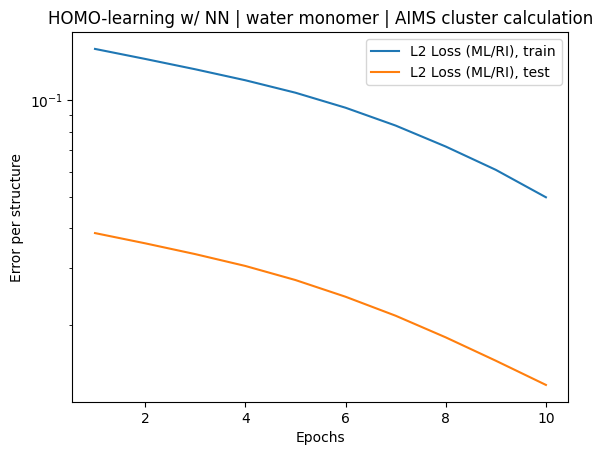

In [29]:
# Load training log
losses = np.loadtxt(os.path.join(ml_dir, "training.log"))

# Unpack data from each row
epochs, train_loss, test_loss, times = losses.T

# Plot the various errors
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label="L2 Loss (ML/RI), train")
ax.plot(epochs, test_loss, label="L2 Loss (ML/RI), test")

ax.set_xlabel("Epochs")
ax.set_ylabel("Error per structure")
ax.set_yscale("log")
ax.set_title("HOMO-learning w/ NN | water monomer | AIMS cluster calculation")
ax.legend()

* This process is slow in a notebook - better to make use of HPC resources! The
  training procedure can essentially be copied to a seperate python script and
  run using a job scheduler - see "run_training.py".

* We can load a model that has been pre-trained and validate its performance

* Here we load a model trained to over 1500 epochs, only a dataset of only 10
  water molecules.

## Evaluate model performance on validation set



In [30]:
# Load pre-trained model and the training log file
model = torch.load(os.path.join(top_dir, "pretrained_models", "model_1611.pt"))
log_file = np.loadtxt(os.path.join(top_dir, "pretrained_models", "training.log"))

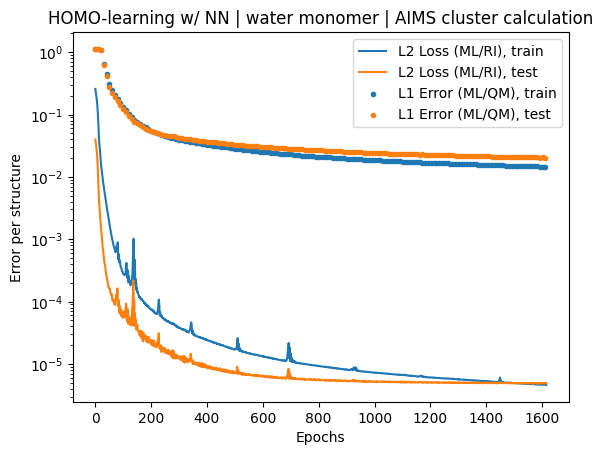

In [31]:
# Unpack data from each row
epochs, train_loss, test_loss, train_mae, test_mae, val_mae, times = log_file.T

# Plot the various errors
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label="L2 Loss (ML/RI), train")
ax.plot(epochs, test_loss, label="L2 Loss (ML/RI), test")
ax.scatter(
    epochs[np.where(train_mae != -1)],
    train_mae[np.where(train_mae != -1)] / 100,
    label="L1 Error (ML/QM), train",
    marker=".",
)
ax.scatter(
    epochs[np.where(test_mae != -1)],
    test_mae[np.where(test_mae != -1)] / 100,
    label="L1 Error (ML/QM), test",
    marker=".",
)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error per structure")
ax.set_yscale("log")
ax.set_title("HOMO-learning w/ NN | water monomer | AIMS cluster calculation")
ax.legend()

## End-to-end prediction on the validation set

* Now let's make an end-to-end prediction (from xyz -> real-space scalar field)
  on the validation set

In [36]:
# Load the validation frames as ASE Atoms objects
val_frames = [all_frames[A] for A in val_idxs]

def val_dir(A):
    return os.path.join(ml_dir, "validation", f"{A}")

# Make predictions for the validation set. Note: we could predict from the
# descriptors that are already constructed here, but do so from ASE frames for
# demonstrative purposes
pred_coeffs = model.predict(
    structure_idxs=val_idxs, frames=val_frames, build_target=False, save_dir=val_dir
)